In [1]:
import keras
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, RepeatVector, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Concatenate, Activation
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
from scipy import misc
import scipy.misc
import random
from tempfile import mkdtemp
import os.path as path

np.random.seed(1337)

import tensorflow as tf
import torch

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
session = tf.Session(config=config)
K.set_session(session)

/home/martin/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
from numpy import array,flipud,shape,zeros,rot90,ceil,floor,sqrt
from scipy import io,reshape,size
import scipy
import pylab
 
def montage(X, colormap="gray"):    
    m, n, count = shape(X)    
    mm = int(ceil(sqrt(count)))
    nn = mm
    M = ones((mm * m, nn * n))

    image_id = 0
    for j in range(mm):
        for k in range(nn):
            if image_id >= count: 
                break
            sliceM, sliceN = j * m, k * n
            M[sliceN:sliceN + n, sliceM:sliceM + m] = X[:, :, image_id]
            image_id += 1
             
    plt.figure(figsize=(10, 10))       
    plt.imshow(flipud(rot90(M)), cmap=colormap)
    plt.axis('off')             
    return M

In [3]:
from keras.layers import Dropout

def conv_block(cnn, channels, filter_size=3, stride=1, padding='valid'):
    cnn = Conv2D(channels, filter_size, padding=padding, strides=stride)(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Activation('relu')(cnn)
    return cnn

def build_style_net(style_image):
    
    style_cnn = conv_block(style_image, 8)
    style_cnn = MaxPooling2D()(style_cnn) 

    style_cnn = conv_block(style_cnn, 16)
    style_cnn = conv_block(style_cnn, 16)
    style_cnn = MaxPooling2D()(style_cnn) 

    style_cnn = conv_block(style_cnn, 32)
    style_cnn = conv_block(style_cnn, 32)
    style_cnn = MaxPooling2D()(style_cnn) 

    style_cnn = conv_block(style_cnn, 64)
    style_cnn = conv_block(style_cnn, 512, 1)
    
    style_cnn = GlobalMaxPooling2D()(style_cnn)
    style_cnn = BatchNormalization()(style_cnn)
    
    return style_cnn


def build_g_net(style_cnn, label_input):    
    
    label_nn = Dense(128)(label_input)
    label_nn = BatchNormalization()(label_nn)
    
    cnn = Concatenate(axis=-1)([style_cnn, label_nn])
    
    cnn = Dense(2048, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dense(2048, activation='relu')(cnn)
    cnn = BatchNormalization()(cnn)
    cnn = Dense(4608, activation='relu')(cnn)
    cnn = Reshape([12,12,-1])(cnn)
    cnn = UpSampling2D(size=(2, 2))(cnn)
    cnn = conv_block(cnn, 128, 3, padding='same')
    cnn = conv_block(cnn, 128, 3, padding='same')
    cnn = UpSampling2D(size=(2, 2))(cnn)
    cnn = conv_block(cnn, 64, 3, padding='same')
    cnn = conv_block(cnn, 64, 3, padding='same')
    cnn = UpSampling2D(size=(2, 2))(cnn)
    cnn = conv_block(cnn, 32, 3, padding='same')
    cnn = conv_block(cnn, 32, 3, padding='same')
    #channel axis reduction
    cnn = Conv2D(1, 3, padding='same')(cnn)#, activation='sigmoid'
    
    return cnn


def build_d_net(style_cnn, image_in):    
    cnn = Conv2D(32, 3, padding='same')(image_in)
    cnn = Activation('elu')(cnn)
    cnn = MaxPooling2D(2)(cnn)
    cnn = Conv2D(64, 3, padding='same')(cnn)
    cnn = Activation('elu')(cnn)
    cnn = MaxPooling2D(2)(cnn)
    cnn = Conv2D(128, 3, padding='same')(cnn)
    cnn = Activation('elu')(cnn)
    cnn = MaxPooling2D(2)(cnn)
    cnn = Conv2D(256, 3, padding='same')(cnn)
    cnn = Activation('elu')(cnn)
    cnn = Conv2D(256, 3, padding='same')(cnn)
    cnn = Activation('elu')(cnn)
    cnn = MaxPooling2D(2)(cnn)
    
    cnn = Flatten()(cnn)
    cnn = Concatenate(axis=-1)([cnn, style_cnn]) 
    
    cnn = Dense(1024, activation='elu')(cnn)
    cnn = Dropout(0.2)(cnn)
    cnn = Dense(1024, activation='elu')(cnn)
    cnn = Dropout(0.2)(cnn)
    cnn = Dense(1, activation='sigmoid')(cnn)
    
    return cnn

In [4]:
n_letters = 62

# Adam parameters suggested in https://arxiv.org/abs/1511.06434
adam_lr = 0.001
style_width = 500
im_size = 64
#create new model

style_image = Input(shape=[im_size, style_width, 1], name='style_image')    
label_input = Input(shape=[n_letters,], name='label_input' )    
char_image = Input(shape=[im_size, im_size, 1], name='char_image')    

s_g_net = build_style_net(style_image)
g_net = build_g_net(s_g_net, label_input)  
g_model = Model([style_image, label_input], g_net)

s_d_net = build_style_net(style_image)
d_net = build_d_net(s_d_net, char_image)  
d_model = Model([style_image, char_image], d_net)

gan_net = d_model([style_image, g_net])
gan_model = Model([style_image, label_input], [g_net, gan_net])

In [5]:
g_model.summary()
d_model.summary()
gan_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
style_image (InputLayer)         (None, 64, 500, 1)    0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 62, 498, 8)    80          style_image[0][0]                
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 62, 498, 8)    32          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 62, 498, 8)    0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

In [6]:
for l in d_model.layers:
    l.trainable = False
    
gan_model.compile(loss=['mean_absolute_error', 'binary_crossentropy'], loss_weights=[1, 0.003], optimizer=Adam(lr=0.0002), metrics=['accuracy'])

for l in d_model.layers:
    l.trainable = True

In [7]:
d_model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.0001), metrics=['accuracy'])#lr=0.001


In [8]:
g_model = keras.models.load_model('MODEL_2/g_model')
from PIL import Image, ImageDraw, ImageFont
tmp_image_as_np=0
alphabet = '0123456789aAbBcCdDeEfFgGhHiIjJkKlLmMnNoOpPqQrRsStTuUvVwWxXyYzZ'
font_folder = '/home/martin/Documents/good_fonts_filtered/'
text_as_words_file = '/media/martin/MartinK3TB/Experiments/capturing_fonts/harry_potter_english.txt'
with open(text_as_words_file) as f:
    text_as_words = f.readlines()
#remove whitespace characters like `\n` at the end of each line
text_as_words = [x.strip() for x in text_as_words] 

class DataGenerator(object):
    'Generates data for Keras'
    def __init__(self, im_size = 64, style_width = 250, batch_size = 32, n_letter_examples=8, shuffle = True):
        'Initialization'
        self.im_size = im_size
        self.style_width = style_width
        self.batch_size = batch_size
        self.n_letter_examples = n_letter_examples
        self.shuffle = shuffle

    def generate(self, list_IDs):
        'Generates batches of samples'
        # Infinite loop
        while 1:
            # Generate order of exploration of dataset
            indexes = self.__get_exploration_order(list_IDs)

            # Generate batches
            imax = int(len(indexes)/self.batch_size)
            for i in range(imax):
                # Find list of IDs
                list_IDs_temp = [list_IDs[k] for k in indexes[i*self.batch_size:(i+1)*self.batch_size]]

                # Generate data
                X, y = self.__data_generation(list_IDs_temp)

                yield X, y

    def __get_exploration_order(self, list_IDs):
        'Generates order of exploration'
        # Find exploration order
        indexes = np.arange(len(list_IDs))
        if self.shuffle == True:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, list_IDs_temp):
        'Generates data of batch_size samples' # X : (n_samples, v_size, v_size, v_size, n_channels)
        # Initialization
        X = {'style_image': np.empty((self.batch_size, self.im_size, self.style_width, 1), dtype=np.float32), 
             'label_input': np.zeros((self.batch_size, n_letters), dtype=np.float32)}
        y = np.empty((self.batch_size, self.im_size, self.im_size, 1), dtype=np.float32)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            while True:
                try:
                    #open font
                    #print(font_folder+str(ID)+".font", i)
                    font = ImageFont.truetype(font_folder+str(ID)+".font", fontsize)

                    #random text
                    which_text = randint(0, len(text_as_words)-10)
                    words = ' '.join(text_as_words[which_text:which_text+15])

                    #style - piece of text in some font
                    image = Image.new("L", (self.style_width, self.im_size))
                    draw = ImageDraw.Draw(image)
                    w, h = draw.textsize(words, font=font)
                    draw.text(((self.style_width-w)/2,(self.im_size-h)/2), words, 255, font=font)

                    image_as_np = numpy.array(image, dtype=np.float32)
                    if np.amax(image_as_np)<255:
                        #print 'blank!'
                        raise ValueError('A very specific bad thing happened.')
                    X['style_image'][i, :, :, 0] = image_as_np/256 #np.expand_dims(im/np.max(im), axis=2)

                    #chose random letter
                    letter = randint(0, n_letters)

                    #output - one letter in one font
                    image = Image.new("L", (self.im_size, self.im_size))
                    draw = ImageDraw.Draw(image)

                    w, h = draw.textsize(alphabet[letter], font=font)
                    draw.text(((self.im_size-w)/2,(self.im_size-h)/2), alphabet[letter], 255, font=font)

                    image_as_np = numpy.array(image, dtype=np.float32)
                    y[i, :, :, 0] = 0.05+(image_as_np/256)*0.9 #np.expand_dims(im/np.max(im), axis=2)

                    #content - one hot
                    X['label_input'][i,letter]=1
                    
                    break
                except Exception:
                    #print('error with font '+str(ID))
                    ID=randint(0, num_fonts)#if there's a problem of any sort, just use another font
        return X, y

/home/martin/venv/local/lib/python2.7/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
num_fonts = 222462
batch_size = 32
num_images = num_fonts
train_ratio = 0.99
fontsize=50
arr = np.arange(num_images)
np.random.shuffle(arr)
arr[0:np.floor(num_images*train_ratio).astype(int)] = sort(arr[0:np.floor(num_images*train_ratio).astype(int)])
partition={'train': arr[0:np.floor(num_images*train_ratio).astype(int)], 'validation': arr[np.ceil(num_images*train_ratio).astype(int):-1]}
training_generator = DataGenerator(im_size=im_size, style_width = style_width, batch_size=batch_size).generate(partition['train'])
validation_generator = DataGenerator(im_size=im_size, style_width = style_width, batch_size=16).generate(partition['validation'])

In [10]:
val_example = validation_generator.next()

In [11]:
class Val_Example(keras.callbacks.Callback):
    def __init__(self):
        s = 'etaoETAO1379'#alphabet
        self.string = []
        for i in s:
            x = alphabet.find(i)
            #print x
            self.string.append(x)
        self.count = 400
            
    def on_epoch_end(self, batch, logs={}):
        outputs = []
        val_example[0]['style_image'] = val_example[0]['style_image'][:self.count]
        val_example[0]['label_input'] = val_example[0]['label_input'][:self.count]
        
        for i in self.string:
            print i
            val_example[0]['label_input'][...]  = 0
            val_example[0]['label_input'][:, i]  = 1
            output = g_model.predict(val_example[0])
            output = output.reshape(-1, im_size, 1)
            outputs.append(output)

        output = np.concatenate(outputs, axis=1)
        style = val_example[0]['style_image'].reshape(-1, style_width, 1)
                          
        plt.figure(figsize=(18,18))
        plt.subplot(1,2,1)        
        plt.imshow(1-style[:,:,0], cmap='gray')
        plt.axis('off')
        #plt.show()

        output[output<0] = 0
        output[output>1] = 1
        output=1-output
        
        plt.subplot(1,2,2)
        #plt.figure(figsize=(18,8))
        plt.imshow(output[:,:,0],cmap='gray')
        
        #print val_example.shape
        #print output.shape
        scipy.misc.imsave('input.bmp', 1-style[:,:,0])
        scipy.misc.imsave('output.bmp', output[:,:,0])

        plt.axis('off')

        plt.show()
    
mycallback = Val_Example()

In [12]:
g_loss=np.empty(0)
d_loss=np.empty(0)
a_loss=np.empty(0)
d_accuracy=np.empty(0)
a_accuracy=np.empty(0)
a_gen_loss=np.empty(0)
a_dis_loss=np.empty(0)

In [13]:
#create parallel threaded data buffer
import Queue
from threading import Thread
from time import sleep

if True:# not 'thread' in globals():
    finishReading = False
    batchQueue = Queue.Queue(maxsize=10)

    finishReading = False

    def threaded_function():
        while not finishReading:
            all_train_data = training_generator.next()
            batchQueue.put(all_train_data)

    thread = Thread(target=threaded_function)
    thread.start()
    print('RUNNING')

RUNNING


0.0
1.0
18
48
10
38
19
49
11
39
1
3
7
9


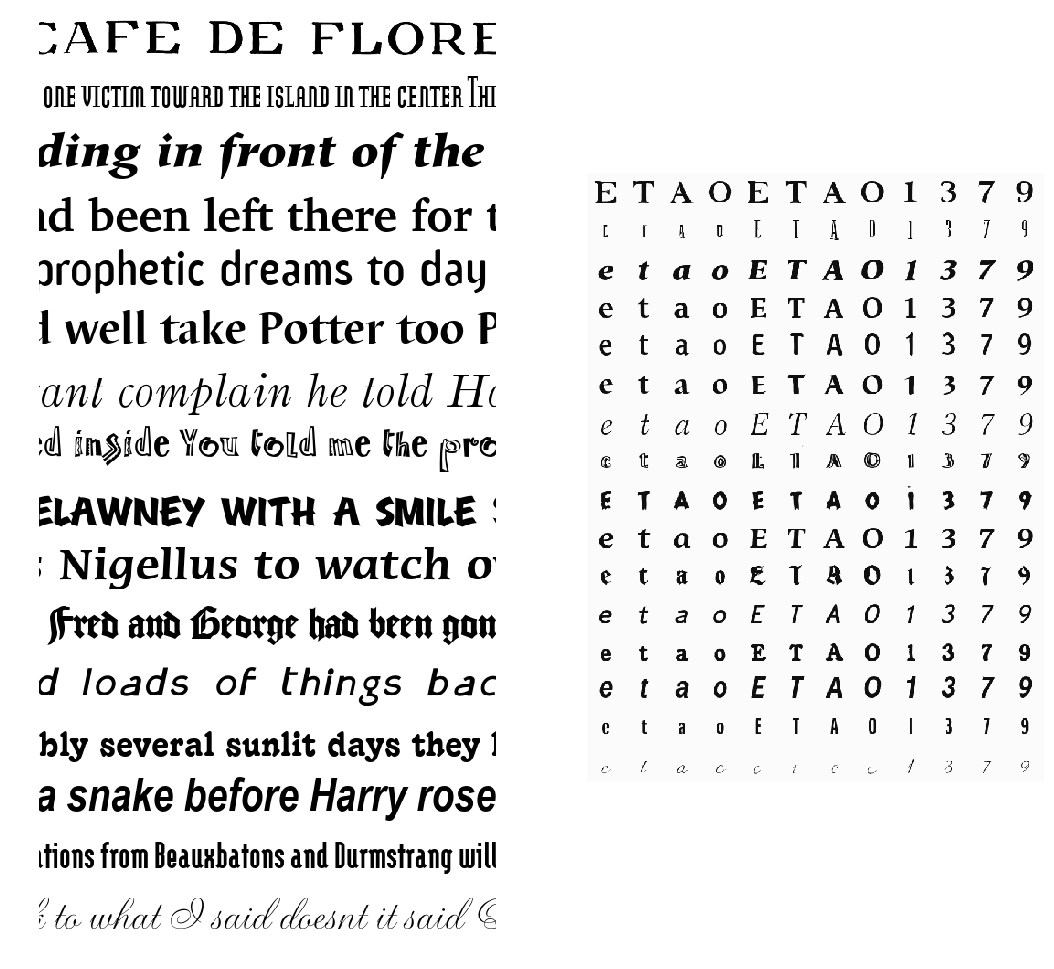

In [18]:
val_example = validation_generator.next()#batchQueue.get()

val_example[0]['style_image'][0].shape
#val_example[0]['style_image'][0,:,:,0] = 1-(scipy.ndimage.imread('/media/martin/MartinK3TB/Experiments/capturing_fonts/paper_figures/hodiny_cnn_in.png', flatten=True)/255)
#val_example[0]['style_image'][1,:,:,0] = 1-(scipy.ndimage.imread('/media/martin/MartinK3TB/Experiments/capturing_fonts/paper_figures/hodiny_cnn_in_2.png', flatten=True)/255)
#val_example[0]['style_image'][2,:,:,0] = 1-(scipy.ndimage.imread('/media/martin/MartinK3TB/Experiments/capturing_fonts/paper_figures/vintage-bell-tower-clock-face-cnn_in.png', flatten=True)/255)
val_example[0]['style_image'][0,:,:,0] = 1-(scipy.ndimage.imread('/media/martin/MartinK3TB/Experiments/capturing_fonts/paper_figures/flore_cnn_64.png', flatten=True)/255)
print np.amin(val_example[0]['style_image'][0])
print np.amax(val_example[0]['style_image'][0])

mycallback.on_epoch_end(0, 0)

In [15]:
niter = 1000000
for iteration in range(1, niter+1):
    all_train_data = batchQueue.get()#non parallel: training_generator.next()
    gen_img = g_model.predict(all_train_data[0])
    
    real_img = all_train_data[1]
    
    #select which come from real and which from gen
    y = np.random.randint(2, size=batch_size)
    X = gen_img
    X[y==1,:,:,:] = real_img[y==1,:,:,:]
    #y = y * 0.95
    d_loss_tmp = d_model.train_on_batch([all_train_data[0]['style_image'], X], y)
    d_loss = np.append(d_loss, d_loss_tmp[0])#loss
    d_accuracy = np.append(d_accuracy, d_loss_tmp[1])#accuracy
    #print d_loss_tmp
    
   
    for l in d_model.layers:
        l.trainable = False
    a_loss_tmp = gan_model.train_on_batch([all_train_data[0]['style_image'], all_train_data[0]['label_input']], [all_train_data[1], np.ones((batch_size, 1))])
    for l in d_model.layers:
        l.trainable = True
    a_gen_loss = np.append(a_gen_loss, a_loss_tmp[1])#loss
    a_dis_loss = np.append(a_dis_loss, a_loss_tmp[2])#loss
    a_accuracy = np.append(a_accuracy, a_loss_tmp[4])#accuracy
    if iteration % 50==0:
        print a_loss_tmp, d_loss_tmp

    if iteration % 250 == 0:
        print 'iteration', iteration
        print a_loss_tmp, d_loss_tmp
        mycallback.on_epoch_end(0, 0)
        plt.plot(d_accuracy)
        plt.show()

ValueError: Error when checking target: expected conv2d_14 to have shape (None, 96, 96, 1) but got array with shape (32, 64, 64, 1)

In [ ]:
if False:
    training_history = g_net.fit_generator(generator = training_generator,
                    steps_per_epoch = len(partition['train'])//batch_size,
                    validation_data = validation_generator,
                    validation_steps = len(partition['validation'])//batch_size,
                    epochs=100, verbose=1, use_multiprocessing=True, workers=3,
                    initial_epoch=0, callbacks=[mycallback])

In [ ]:
d_model.save('./MODEL_2/d_model_96')
gan_model.save('./MODEL_2/gan_model_96')
g_model.save('./MODEL_2/g_model_96')